# Smart scanning
This Jupyter is to simulate different operations of a smart scanner.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from smart_scan.helpers.function_helpers import mask2active_pixels, generate_mask, ScanningStragies
import ipywidgets as widgets
from PIL import Image
from smart_scan.devices import Galvo_Scanners

In [2]:
# Load a mask
im = Image.open('resources/Mask_big_2.tif')
mask = np.array(im)

# For testing. Max size of the ones mask tested: 2048 x 2048
#mask = np.ones([2048,2048])

h = mask.shape[0]
w = mask.shape[1]
ps = 102.4 / h # pixel size so that the total field of view is ~ 100 x 100 µm2

print(f"Mask is {h}x{w} pixels; pixelsize = {ps}µm. Total field of view: {h*ps} x {w*ps} µm^2")

Mask is 2048x2048 pixels; pixelsize = 0.05µm. Total field of view: 102.4 x 102.4 µm^2


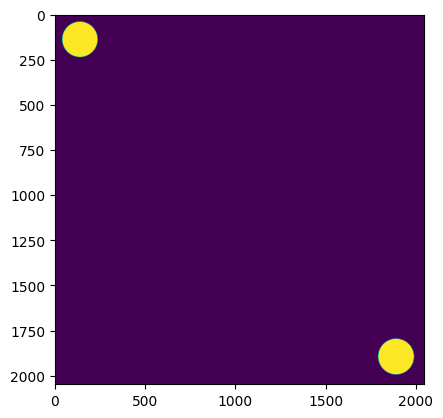

In [3]:
# Show the mask
plt.imshow(mask)

In [4]:
# Create the Galvo_Scanners object
gs = Galvo_Scanners()

In [5]:
# Connects it
gs.connect()

In [ ]:
# Scans the non-zero pixels of the mask
gs.scan(mask=mask,pixelsize=ps,scan_strategy= ScanningStragies.SNAKE,duration=5, triggered=True, timeout=10)

Scaling: UINT16
Scaling: UINT16
duration: 5
rate: 12192.8
rate > 10000.0 Hz: no voltage output generated


In [7]:
# Disconnects the device
gs.disconnect()

## Laser communication

In [8]:
from smart_scan.pyserial import Laser

In [13]:
from serial import SerialException

try:
    laser = Laser()

    laser.send("!pass TuiOptics\r")

    laser.send(laser.on)

    laser.send("sh level power")

    laser.send(laser.off)

    laser.disconnect()

    #laser.send("sh sat\r")
    # time.sleep(1)
    # laser.send(laser.set_power(10))
    # time.sleep(1)
    # laser.send(laser.show_power)
    # laser.send("switch reset\r")
    # time.sleep(1)
    # laser.send("switch 4 high\r")
    # laser.send("las on\r")
    # laser.send("switch 4 low\r")
    # laser.send("show switch\r")
    #laser.send("ch 2 pow 5 mic\r")
    #laser.send("config modu sub\r")
    # laser.send("trim modu\r")


except SerialException:
    print("Could not connect laser")  

Could not connect laser


### The following was used to check every function then used in the Galvo_Scanners class

In [15]:
# 1: define the image and mask sizes
semidim_w = 5 # pixels
semidim_h = 9 # pixels

# 2a: generate a binary mask to know where we want to scan
h = 100 # pixels
w = 100 # pixels
mask = generate_mask(h,w, semidim_h, semidim_w)

# 2b load a mask
# mask = imarray
# h = mask.shape[0]
# w = mask.shape[1]

# 3: convert the mask to active pixels, so be sent to the controller
pixel_sequence = mask2active_pixels(mask, scan_strategy=ScanningStragies.RASTER)

# 4: convert the pixels in voltages
voltage_sequence = gs._pixels2voltages(pixel_sequence = pixel_sequence, pixelsize=ps)


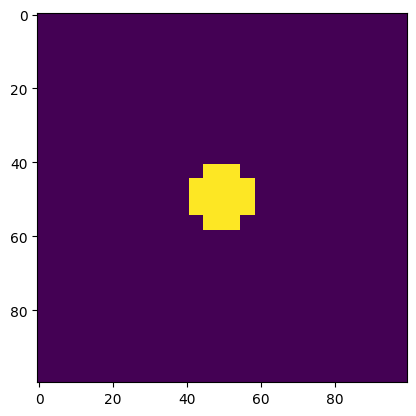

In [16]:
plt.imshow(mask)

In [17]:
tmp_mask = np.zeros([h,w,len(pixel_sequence)])
for idx, pixel in enumerate(pixel_sequence):
    tmp_mask[pixel[0],pixel[1],idx] = 1
    
# Threshold and show the image
slice = widgets.IntSlider(description='slice',min = 0, max = len(pixel_sequence)-1)

def show_scan(slice):
    data = tmp_mask[:,:,slice]
    fig = plt.imshow(data)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

def show_voltage(slice):
    print(f'Voltage_x [mV]: {voltage_sequence[slice][1]}')
    print(f'Voltage_y [mV]: {voltage_sequence[slice][0]}')
    

    
scan = widgets.interactive_output(show_scan, {'slice': slice})
voltage = widgets.interactive_output(show_voltage, {'slice': slice})
widgets.HBox([ widgets.VBox([slice, scan]), voltage ]) 


In [18]:
data_x = np.transpose(voltage_sequence)[0].copy()
data_y = np.transpose(voltage_sequence)[1].copy()

#calculated properties
max_voltage = 5000 #[mv]
min_voltage = 0

# Limits the voltage output
data_x[data_x>=max_voltage] = max_voltage
data_x[data_x<=min_voltage] = min_voltage
data_y[data_y>=max_voltage] = max_voltage
data_y[data_y<=min_voltage] = min_voltage

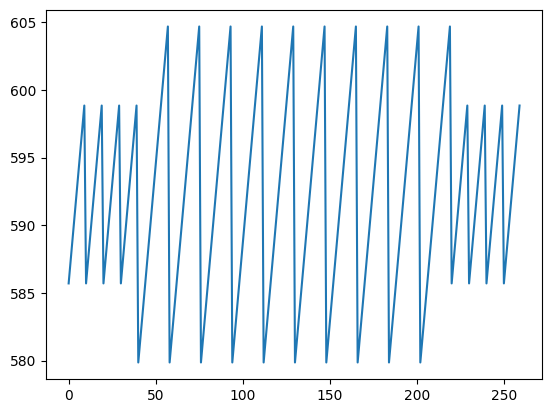

In [19]:
# Plot the voltage over time
plt.plot(data_y)
# plt.xlim([0,100])

In [ ]:
# AnalogOut expects double normalized to +/-1 value
data_x *= (2**16-1)/max_voltage
data_x = np.uint16(data_x)


data_y *= (2**15-1)/max_voltage
data_y = np.uint16(data_y)

n_samples = len(data_x)
# The duration of the whole scan
duration = 1 # s
dwell_time = duration / n_samples
rate = n_samples/duration # Hz

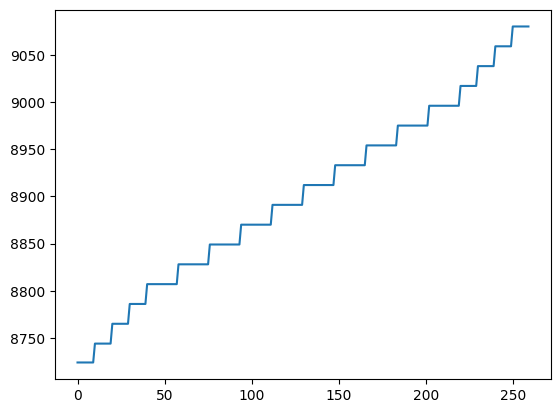

In [ ]:
plt.plot(data_x)